# Detection of Master Regulators on a dummy example

This vignette displays some examples of what can be achieved using **NORDic** in order to detect master regulators.

## Installation

In [1]:
import NORDic
! pip freeze | grep "NORDic"

NORDic==2.2.6


## Detection of master regulators

**NORDic PMR** exploits a Boolean network in order to find master regulators. Its approach is based on influence maximization. For more information about the method, please have a look at the following [reference](https://clreda.github.io/assets/reda2022prioritization_accepted.pdf):


> Réda, C., & Delahaye-Duriez, A. (2022). Prioritization of Candidate Genes Through Boolean Networks. In *International Conference on Computational Methods in Systems Biology* (pp. 89-121). Springer, Cham.


The input network does not need to be an output of **NORDic NI**, and the corresponding .BNET file can be independenty generated. We illustrate this by feeding to **NORDic PMR** a dummy example.

In [2]:
from subprocess import call as sbcall
save_folder="MODELS/dummy/"
sbcall("mkdir -p "+save_folder, shell=True)

0

### A. Creating the dummy network example

The dummy example has 11 genes named X0, X1, ..., X10 (with one isolated gene X10), and 20 edges. We expect X0 and X1 to be  master regulators, and X10 to have no influence on the network (because it is isolated). Let us test this using **NORDic PMR**.

In [3]:
import pandas as pd
import numpy as np

## List of input nodes for each edge
source = list(map(lambda x: "X%d" % x,[0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,2,3,4,5]))
## List of target nodes for each edge
target = list(map(lambda x : "X%d" % x,[2,3,4,5,6,7,8,9,2,3,4,5,6,7,8,9,6,7,8,9]))

## List of all genes
genes = list(sorted(list(set(source+target))))+["X10"]

## Create the network (adjacency matrix)
influences = np.zeros((len(genes), len(genes)))
for s, t in zip(source, target):
    influences[genes.index(s)][genes.index(t)] = 1
influences = pd.DataFrame(influences, index=genes, columns=genes).astype(int)
influences

,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10
X0,0,0,1,1,1,1,1,1,1,1,0
X1,0,0,1,1,1,1,1,1,1,1,0
X2,0,0,0,0,0,0,1,0,0,0,0
X3,0,0,0,0,0,0,0,1,0,0,0
X4,0,0,0,0,0,0,0,0,1,0,0
X5,0,0,0,0,0,0,0,0,0,1,0
X6,0,0,0,0,0,0,0,0,0,0,0
X7,0,0,0,0,0,0,0,0,0,0,0
X8,0,0,0,0,0,0,0,0,0,0,0
X9,0,0,0,0,0,0,0,0,0,0,0


Let us plot the network using **NORDic** functions, and save the corresponding image in *save_folder*/example.png. Parameter *optional* traces edges with dashed lines when set to True, resp. with solid lines when set to False.

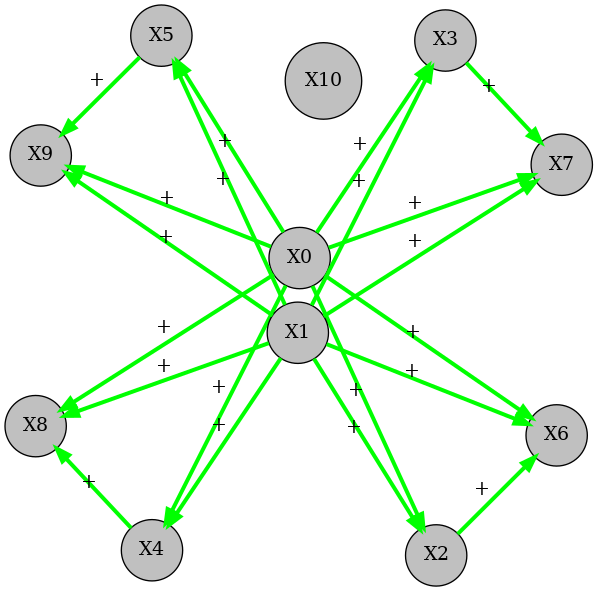

In [4]:
from NORDic.UTILS.utils_plot import influences2graph

influences2graph(influences, save_folder+"example", optional=False, 
                 compile2png=True, engine="sfdp")
from IPython.display import Image
Image(filename=save_folder+'example.png') 

Now that we have built the topology of the network, its dynamics remain to be defined. In that case, we assume that all activators (i.e., regulators connected with an activatory edge) should be active (i.e., an "active" expression level) for the regulated gene to be active.

In [5]:
## Gene regulatory functions (for each node in the network)
grfs = {}
for si, s in enumerate(source):
    t = target[si]
    grf = grfs.get(t, [])
    grfs.update(dict([[t, list(set(grf+[s]))]]))

Now, let us write down the corresponding .BNET file *save_folder*/example.bnet

In [6]:
with open(save_folder+"example.bnet", "w") as f:
    network = []
    for g in genes:
        if (g in grfs):
            network += [g+", "+"&".join(grfs[g])]
        else:
            network += [g+", 1"]
    f.write("\n".join(network))
    
## Print the resulting network
with open(save_folder+"example.bnet", "r") as f:
    network = f.read()
print("\n".join([", ".join(s.split(", ")) for s in network.split("\n")]))

X0, 1
X1, 1
X2, X1&X0
X3, X1&X0
X4, X1&X0
X5, X1&X0
X6, X1&X0&X2
X7, X3&X1&X0
X8, X1&X0&X4
X9, X1&X5&X0
X10, 1


### B. Creating random "patient" samples

In **NORDic PMR**, the ability of a given gene to disrupt the expression of the whole network is tested in a specific disease-related transcriptional context, i.e., patient transcriptional profiles ("states"). Since here the nodes in the network are not related to actual genes, we generate 100 binary states at random. Those states should be a dataframe, with samples/patients in columns, genes in rows.

In [7]:
state_len = 200
states = pd.DataFrame(
  [np.random.choice([0,1], p=[0.5,0.5], size=len(genes)).tolist() for _ in range(state_len)]
  , columns=genes, index=range(state_len)).T
states

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
X0,0,0,0,1,1,1,0,0,1,0,...,0,0,0,0,0,1,1,1,0,0
X1,1,1,1,1,1,1,1,1,0,1,...,0,0,0,0,0,1,0,0,1,1
X2,0,0,1,0,1,1,0,1,0,1,...,0,1,1,0,1,1,1,0,1,1
X3,0,1,0,0,0,0,0,0,1,1,...,0,0,1,0,0,1,0,1,1,1
X4,1,1,1,1,0,0,0,0,0,0,...,1,1,0,0,0,0,1,1,0,1
X5,0,1,0,0,0,1,0,1,0,0,...,0,0,1,1,0,1,1,1,1,0
X6,1,0,0,1,1,0,1,1,1,0,...,1,0,1,0,1,1,1,1,0,1
X7,1,1,1,1,1,0,0,1,1,0,...,1,1,1,1,0,1,0,1,0,1
X8,0,0,1,1,0,0,1,0,0,0,...,1,0,0,0,0,0,1,0,1,1
X9,0,1,0,1,1,0,1,1,1,1,...,1,0,1,0,0,0,0,1,0,1


### C. Selection of parameters

Again, we need to set the random seed for increased reproducibility, and set the maximum number of threads to use:

In [8]:
seed_number=0
from multiprocessing import cpu_count
njobs=min(5,max(1,cpu_count()-2)) #minimum between all available -2 and 5

In order to prove our conjecture (that X0 and X1 are the most regulatory in this network), we set k to 2, that is, we return all the sets of 2 nodes in the network that *roughly* (see paper) maximize the perturbation of the whole network.

In [9]:
k=2

The perturbation of the network should be computed for each gene in the network (list *gene_inputs*), on every "regulatable" gene (that is, a gene which has at least one regulator which is not itself) (list *genes_outputs*).

In [10]:
## Compute the list of "regulatable" genes from the network
with open(save_folder+"example.bnet", "r") as f:
    network = f.read()
gene_outputs = [ x.split(", ")[0] for x in network.split("\n")[:-1] 
    if (x.split(", ")[1] not in [x.split(", ")[0], "0", "1"])]

IM_params = {
    "seed": seed_number, "gene_inputs": genes, # genes to be perturbed
    "gene_outputs": gene_outputs # genes to be observed
}

Let us now set parameters relative to the simulations of trajectories under perturbation of the network (see [mpbn-sim](https://github.com/bnediction/mpbn-sim)):

In [11]:
SIMU_params = {
    'nb_sims': 1000, 'rates': "fully_asynchronous", 'thread_count': njobs,
    'depth': "constant_unitary",
}

All in all

In [12]:
seed_number=12345
from multiprocessing import cpu_count
njobs=min(5,max(1,cpu_count()-2))

k=2

with open(save_folder+"example.bnet", "r") as f:
    network = f.read()
gene_outputs = [ x.split(", ")[0] for x in network.split("\n")[:-1] 
    if (x.split(", ")[1] not in [x.split(", ")[0], "0", "1"])]

IM_params = {
    "seed": seed_number, "gene_inputs": genes,
    "gene_outputs": gene_outputs
}

SIMU_params = {
    'nb_sims': 1000, 'rates': "fully_asynchronous", 'thread_count': njobs,
    'depth': "constant_unitary",
}

### D. Detection of master regulators

Function *greedy* implements the approximately optimal greedy algorithm from the following paper

>Kempe, David, Jon Kleinberg, and Éva Tardos. "Maximizing the spread of influence through a social network." Proceedings of the ninth ACM SIGKDD international conference on Knowledge discovery and data mining. 2003.

It returns the predicted set of master regulators, along with the *spread values* computed at each step of the algorithm for each node. Spread values are correlated with the ability to disrupt the expression of the network (see paper).

In [13]:
from NORDic.NORDic_PMR.functions import greedy

S, spreads = greedy(save_folder+"example.bnet", k, states, IM_params, SIMU_params, 
                    save_folder=save_folder)

<NORD_PMR> Iteration k=1
	<NORD_PMR> Initial state 0 (gene(s):X0)
	<NORD_PMR> Initial state 1 (gene(s):X0)
1 wild type attractors with proba > 0 (initial state 0)
Gene X0 (1/11) in state 0 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 2 (gene(s):X0)
1 wild type attractors with proba > 0 (initial state 1)
Gene X0 (1/11) in state 1 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 0 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 4 (gene(s):X0)
Gene X1 (2/11) in state 1 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 2)
Gene X0 (1/11) in state 2 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 0 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 3 (gene(s):X0)
Gene X2 (3/11) in state 1 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (ini

  0%|          | 0/1000 [00:00<?, ?it/s]

Gene X4 (5/11) in state 0 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 1 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 3 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 4 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 2 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 0 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 3 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 1 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 4 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 2 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 0 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 3 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 1 - constant_uni

100%|██████████| 1/1 [00:00<00:00, 38479.85it/s]

100%|██████████| 1000/1000 [00:00<00:00, 43273.71it/s]

Gene X7 (8/11) in state 4 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 1 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 3 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 2 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 0 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 4 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 3 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 2 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 4 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 3 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 5 (gene(s):X0)
	<NORD_PMR> Initial state 6 (gene(s):X0)
Gene X10 (11/11) in state 4 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 3


100%|██████████| 1000/1000 [00:00<00:00, 43842.29it/s]


Gene X1 (2/11) in state 7 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 6 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 9)
Gene X0 (1/11) in state 9 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 8)
Gene X0 (1/11) in state 8 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 5 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 7 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 6 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 9 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 8 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 5 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 7 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 

  0%|          | 0/1000 [00:00<?, ?it/s]

Gene X5 (6/11) in state 8 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 5 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 7 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 6 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 9 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 5 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 8 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 7 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 6 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 9 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 7 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 5 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 8 - constan


  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 37786.52it/s]

100%|██████████| 1/1 [00:00<00:00, 45590.26it/s]

100%|██████████| 1/1 [00:00<00:00, 36472.21it/s]

100%|██████████| 1000/1000 [00:00<00:00, 48371.63it/s]

	<NORD_PMR> Initial state 13 (gene(s):X0)
Gene X1 (2/11) in state 11 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 10 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 14 (gene(s):X0)
Gene X1 (2/11) in state 12 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 13)
Gene X2 (3/11) in state 11 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X0 (1/11) in state 13 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 14)
Gene X0 (1/11) in state 14 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 10 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 12 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 11 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 13 - constant_unitary_depth{}	fully_asynchronous_


100%|██████████| 1000/1000 [00:00<00:00, 29585.90it/s]domRec ignored: No domain atoms found.

  0%|          | 0/1000 [00:00<?, ?it/s]

Gene X6 (7/11) in state 11 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 14 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 10 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 13 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 12 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 14 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 11 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 10 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 13 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 14 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 12 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 10 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 11 


100%|██████████| 1/1 [00:00<00:00, 46603.38it/s]

100%|██████████| 1000/1000 [00:00<00:00, 27216.48it/s]

100%|██████████| 1/1 [00:00<00:00, 34100.03it/s]

100%|██████████| 1/1 [00:00<00:00, 32017.59it/s]

	<NORD_PMR> Initial state 17 (gene(s):X0)
Gene X10 (11/11) in state 13 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 18 (gene(s):X0)
1 wild type attractors with proba > 0 (initial state 17)
1 wild type attractors with proba > 0 (initial state 16)
Gene X0 (1/11) in state 16 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X0 (1/11) in state 17 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 15 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 19 (gene(s):X0)
1 wild type attractors with proba > 0 (initial state 18)
Gene X0 (1/11) in state 18 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 17 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 16 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 15 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 17 - constant_unitary_depth{}


  0%|          | 0/1000 [00:00<?, ?it/s]

Gene X2 (3/11) in state 19 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 17 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 18 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 15 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 16 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 19 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 17 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 18 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 15 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 16 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 17 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 19 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 18 -

100%|██████████| 1000/1000 [00:00<00:00, 34910.93it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

	<NORD_PMR> Initial state 20 (gene(s):X0)
Gene X10 (11/11) in state 16 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 15 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 18 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 19 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 21 (gene(s):X0)
	<NORD_PMR> Initial state 22 (gene(s):X0)
1 wild type attractors with proba > 0 (initial state 20)
Gene X0 (1/11) in state 20 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 23 (gene(s):X0)
Gene X9 (10/11) in state 19 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 21)
Gene X0 (1/11) in state 21 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 20 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 22)
Gene X

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 45100.04it/s]

100%|██████████| 1000/1000 [00:00<00:00, 32526.34it/s]

Gene X4 (5/11) in state 20 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 23 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 22 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 21 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 24 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 20 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 23 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 22 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 21 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 24 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 20 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 23 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 21 -


100%|██████████| 1000/1000 [00:00<00:00, 42304.32it/s]

Gene X8 (9/11) in state 23 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 22 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 24 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 20 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 21 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 23 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 22 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 25 (gene(s):X0)
Gene X7 (8/11) in state 24 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 26 (gene(s):X0)
Gene X10 (11/11) in state 23 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 22 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 25)
Gene X0 (1/11) in state 25 - constant_u

100%|██████████| 1000/1000 [00:00<00:00, 36513.17it/s]

100%|██████████| 1000/1000 [00:00<00:00, 32306.37it/s]

100%|██████████| 1/1 [00:00<00:00, 48770.98it/s]

100%|██████████| 1000/1000 [00:00<00:00, 35064.15it/s]

Gene X1 (2/11) in state 28 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 27 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 25 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 29 (gene(s):X0)
Gene X3 (4/11) in state 26 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 27 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 28 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 25 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 29)
Gene X0 (1/11) in state 29 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 26 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 27 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 28 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6

100%|██████████| 1000/1000 [00:00<00:00, 23264.08it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Gene X8 (9/11) in state 25 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 27 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 29 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 28 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 26 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 27 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 25 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 29 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 28 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 27 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 26 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 25 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in st

100%|██████████| 1/1 [00:00<00:00, 42366.71it/s]

100%|██████████| 1000/1000 [00:00<00:00, 45820.36it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Gene X0 (1/11) in state 32 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 33)
Gene X0 (1/11) in state 33 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 30 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 29 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 32 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 31 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 33 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 34 (gene(s):X0)
Gene X2 (3/11) in state 30 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 32 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 33 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 34)
Gene X3 (4/11) in state 32 - con


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 34100.03it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 46091.25it/s]

100%|██████████| 1000/1000 [00:00<00:00, 37450.15it/s]

Gene X5 (6/11) in state 30 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 34 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 32 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 33 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 31 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 30 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 34 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 33 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 31 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 32 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 30 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 34 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 33 -

100%|██████████| 1000/1000 [00:00<00:00, 32885.41it/s]

Gene X9 (10/11) in state 34 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 36 (gene(s):X0)
	<NORD_PMR> Initial state 37 (gene(s):X0)
Gene X9 (10/11) in state 31 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 34 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 35)
Gene X0 (1/11) in state 35 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 36)
Gene X0 (1/11) in state 36 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 37)
Gene X0 (1/11) in state 37 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 31 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 38 (gene(s):X0)
Gene X1 (2/11) in state 35 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 37 - constant_unitary_dep


100%|██████████| 1000/1000 [00:00<00:00, 28342.57it/s]

100%|██████████| 1/1 [00:00<00:00, 31775.03it/s]

100%|██████████| 1/1 [00:00<00:00, 25266.89it/s]

100%|██████████| 1000/1000 [00:00<00:00, 33582.10it/s]

Gene X1 (2/11) in state 39 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 37 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 38 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 36 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 35 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 39 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 37 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 38 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 35 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 36 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 39 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 38 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 37 -

100%|██████████| 1000/1000 [00:00<00:00, 37648.14it/s]

100%|██████████| 1000/1000 [00:00<00:00, 39990.31it/s]

Gene X8 (9/11) in state 38 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 36 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 39 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 37 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 35 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 38 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 36 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 39 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 37 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 40 (gene(s):X0)
Gene X10 (11/11) in state 38 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 36 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 39 - constant_unitary_depth{}	fu

100%|██████████| 1000/1000 [00:00<00:00, 44706.82it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:00<00:00, 35990.25it/s]

Gene X1 (2/11) in state 43 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 44 (gene(s):X0)
Gene X1 (2/11) in state 42 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 40 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 41 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 43 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 44)
Gene X0 (1/11) in state 44 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 40 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 41 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 42 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 43 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 40 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5

100%|██████████| 1000/1000 [00:00<00:00, 32526.09it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Gene X7 (8/11) in state 43 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 41 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 44 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 42 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 40 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 43 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 41 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 44 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 43 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 40 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 42 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 41 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in sta


100%|██████████| 1/1 [00:00<00:00, 33825.03it/s]

100%|██████████| 1000/1000 [00:00<00:00, 41530.64it/s]

100%|██████████| 1/1 [00:00<00:00, 27413.75it/s]

100%|██████████| 1/1 [00:00<00:00, 42799.02it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Gene X10 (11/11) in state 42 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 44 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 46 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 45 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 47 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 48 (gene(s):X0)
Gene X10 (11/11) in state 44 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 46 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 45 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 47 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 48)
	<NORD_PMR> Initial state 49 (gene(s):X0)
Gene X0 (1/11) in state 48 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 45 - constant_unitar

100%|██████████| 1000/1000 [00:00<00:00, 27267.79it/s]

100%|██████████| 1/1 [00:00<00:00, 29537.35it/s]

100%|██████████| 1/1 [00:00<00:00, 36472.21it/s]

Gene X7 (8/11) in state 45 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 46 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 48 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 47 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 49 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 45 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 46 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 47 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 48 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 45 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 46 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 47 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 49


100%|██████████| 1/1 [00:00<00:00, 36792.14it/s]

100%|██████████| 1000/1000 [00:00<00:00, 33911.18it/s]

Gene X8 (9/11) in state 48 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 49 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 52)
Gene X0 (1/11) in state 52 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 50 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 51 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 48 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 49 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 52 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 50 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 51 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 52 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 48 - constant_unitary_dep

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 45100.04it/s]

100%|██████████| 1/1 [00:00<00:00, 41527.76it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

	<NORD_PMR> Initial state 54 (gene(s):X0)
Gene X6 (7/11) in state 52 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 51 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 53 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 50 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 53 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 52 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 50 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 54)
Gene X0 (1/11) in state 54 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 51 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 53 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 50 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 45590.26it/s]

100%|██████████| 1/1 [00:00<00:00, 39568.91it/s]

Gene X4 (5/11) in state 54 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 57 (gene(s):X0)
1 wild type attractors with proba > 0 (initial state 56)
Gene X0 (1/11) in state 56 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 53 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 55 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 54 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 53 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 56 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 57)
Gene X0 (1/11) in state 57 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 55 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 54 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 58 (g


100%|██████████| 1000/1000 [00:00<00:00, 32828.27it/s]

100%|██████████| 1000/1000 [00:00<00:00, 41515.43it/s]

Gene X6 (7/11) in state 55 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 57 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 56 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 54 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 58 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 55 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 57 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 56 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 58 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 59 (gene(s):X0)
Gene X8 (9/11) in state 55 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 56 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 57 - constant_unitary_depth{}	fully_async


  0%|          | 0/1000 [00:00<?, ?it/s]

Gene X2 (3/11) in state 59 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 58 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 57 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 60)
Gene X0 (1/11) in state 60 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 58 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 61)
Gene X0 (1/11) in state 61 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 59 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 57 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 60 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 58 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 61 - constant_unitary_depth{}	fully_asynchrono

100%|██████████| 1/1 [00:00<00:00, 39199.10it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Gene X4 (5/11) in state 61 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 63 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 59 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 60 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 62 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 61 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 63 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 60 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 59 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 62 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 61 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 63 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 60 -


100%|██████████| 1000/1000 [00:00<00:00, 30485.18it/s]

Gene X6 (7/11) in state 63 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 61 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 65 (gene(s):X0)
1 wild type attractors with proba > 0 (initial state 64)
Gene X0 (1/11) in state 64 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 62 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 63 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 66 (gene(s):X0)
Gene X1 (2/11) in state 64 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 65)
Gene X0 (1/11) in state 65 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 62 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 63 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 65 - constant_unitary_depth{}	fully_asynchronou


100%|██████████| 1/1 [00:00<00:00, 27776.85it/s]

100%|██████████| 1/1 [00:00<00:00, 39199.10it/s]

100%|██████████| 1/1 [00:00<00:00, 31300.78it/s]

100%|██████████| 1000/1000 [00:00<00:00, 30999.34it/s]

	<NORD_PMR> Initial state 67 (gene(s):X0)
Gene X4 (5/11) in state 65 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 64 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 68 (gene(s):X0)
Gene X3 (4/11) in state 66 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 65 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 67)
Gene X0 (1/11) in state 67 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 64 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 65 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 68)
Gene X0 (1/11) in state 68 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 66 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 67 - constant_unitary_depth{}	fully_asynchronous_


100%|██████████| 1000/1000 [00:00<00:00, 47523.75it/s]

Gene X7 (8/11) in state 66 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 65 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 64 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 67 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 68 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 69 (gene(s):X0)
Gene X8 (9/11) in state 66 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 70 (gene(s):X0)
Gene X6 (7/11) in state 67 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 68 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 69)
Gene X0 (1/11) in state 69 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 66 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 67 - constant_unitar


100%|██████████| 1/1 [00:00<00:00, 30615.36it/s]

100%|██████████| 1000/1000 [00:00<00:00, 39082.59it/s]

Gene X3 (4/11) in state 70 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 69 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 68 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 71)
Gene X0 (1/11) in state 71 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 72 (gene(s):X0)
Gene X5 (6/11) in state 69 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 70 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 68 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 71 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 69 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 72)
Gene X0 (1/11) in state 72 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 70 - co

100%|██████████| 1/1 [00:00<00:00, 33825.03it/s]

100%|██████████| 1000/1000 [00:00<00:00, 43792.85it/s]

100%|██████████| 1000/1000 [00:00<00:00, 40770.08it/s]

Gene X3 (4/11) in state 72 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 71 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 74 (gene(s):X0)
Gene X9 (10/11) in state 70 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 73 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 72 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 70 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 71 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 72 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 73 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 74)
Gene X0 (1/11) in state 74 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 75 (gene(s):X0)
Gene X8 (9/11) in state 71 - constant_unitary_


100%|██████████| 1000/1000 [00:00<00:00, 25246.51it/s]

Gene X1 (2/11) in state 75 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 74 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 76 (gene(s):X0)
Gene X6 (7/11) in state 73 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 72 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 75 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 74 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 76)
Gene X0 (1/11) in state 76 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 73 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 72 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 75 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 74 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1

100%|██████████| 1/1 [00:00<00:00, 26214.40it/s]

100%|██████████| 1/1 [00:00<00:00, 30174.85it/s]


  0%|          | 0/1000 [00:00<?, ?it/s]

Gene X6 (7/11) in state 75 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 74 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 73 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 77 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 76 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 75 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 74 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 78 (gene(s):X0)
Gene X3 (4/11) in state 77 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 76 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 74 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 75 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 77 - constant_unitary_depth{}	fully_as

100%|██████████| 1000/1000 [00:00<00:00, 36898.63it/s]

Gene X1 (2/11) in state 79 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 76 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 77 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 79 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 80)
Gene X0 (1/11) in state 80 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 78 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 81 (gene(s):X0)
Gene X9 (10/11) in state 77 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 80 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 79 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 78 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 77 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wil

100%|██████████| 1/1 [00:00<00:00, 40329.85it/s]

100%|██████████| 1/1 [00:00<00:00, 30840.47it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Gene X1 (2/11) in state 82 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 78 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 80 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 81 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 79 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 82 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 78 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 81 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 80 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 79 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 82 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 81 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 80 -

100%|██████████| 1/1 [00:00<00:00, 32513.98it/s]

100%|██████████| 1/1 [00:00<00:00, 38130.04it/s]

100%|██████████| 1/1 [00:00<00:00, 28926.23it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

1 wild type attractors with proba > 0 (initial state 83)
Gene X10 (11/11) in state 80 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X0 (1/11) in state 83 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 84)
Gene X10 (11/11) in state 81 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X0 (1/11) in state 84 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 82 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 85 (gene(s):X0)
Gene X1 (2/11) in state 83 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 86 (gene(s):X0)
Gene X1 (2/11) in state 84 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 82 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 84 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 83 - constant_unitary_depth{}	fully_asynchron

100%|██████████| 1000/1000 [00:00<00:00, 37612.69it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Gene X5 (6/11) in state 83 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 84 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 85 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 87)
Gene X0 (1/11) in state 87 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 86 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 83 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 84 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 85 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 87 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 86 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 84 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 83 - constant_unitary_depth{

100%|██████████| 1/1 [00:00<00:00, 26214.40it/s]

100%|██████████| 1000/1000 [00:00<00:00, 31457.12it/s]

Gene X5 (6/11) in state 87 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 86 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 83 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 85 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 87 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 88 (gene(s):X0)
Gene X8 (9/11) in state 86 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 85 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 87 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 88)
Gene X0 (1/11) in state 88 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 86 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 87 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X


  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:00<00:00, 29408.53it/s]

Gene X0 (1/11) in state 90 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 92 (gene(s):X0)
Gene X3 (4/11) in state 88 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 89 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 91)
Gene X0 (1/11) in state 91 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 92)
Gene X1 (2/11) in state 90 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X0 (1/11) in state 92 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 88 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 89 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 92 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 91 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 90 - const

100%|██████████| 1/1 [00:00<00:00, 40721.40it/s]

100%|██████████| 1000/1000 [00:00<00:00, 36837.38it/s]

Gene X4 (5/11) in state 91 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 89 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 90 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 92 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 91 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 92 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 89 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 88 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 90 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 91 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 92 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 89 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 90 -


  0%|          | 0/1000 [00:00<?, ?it/s]

Gene X10 (11/11) in state 92 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 91 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 89 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 94 (gene(s):X0)
Gene X10 (11/11) in state 90 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 91 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 93)
Gene X0 (1/11) in state 93 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 95 (gene(s):X0)
	<NORD_PMR> Initial state 96 (gene(s):X0)
	<NORD_PMR> Initial state 97 (gene(s):X0)
1 wild type attractors with proba > 0 (initial state 94)
Gene X0 (1/11) in state 94 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 93 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 95)
Gene


100%|██████████| 1000/1000 [00:00<00:00, 37978.81it/s]

100%|██████████| 1000/1000 [00:00<00:00, 37293.31it/s]

Gene X3 (4/11) in state 93 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 97 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 94 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 96 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 95 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 93 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 97 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 96 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 94 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 95 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 97 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 93 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 94 -


100%|██████████| 1000/1000 [00:00<00:00, 44257.25it/s]

100%|██████████| 1/1 [00:00<00:00, 35848.75it/s]

100%|██████████| 1000/1000 [00:00<00:00, 29465.76it/s]

100%|██████████| 1/1 [00:00<00:00, 41120.63it/s]

100%|██████████| 1/1 [00:00<00:00, 33288.13it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Gene X6 (7/11) in state 95 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 94 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 96 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 97 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 93 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 95 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 96 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 97 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 94 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 93 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 96 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 95 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in stat

  0%|          | 0/1000 [00:00<?, ?it/s]

1 wild type attractors with proba > 0 (initial state 101)
Gene X0 (1/11) in state 101 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 98 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 99 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 102 (gene(s):X0)
Gene X1 (2/11) in state 100 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 101 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 98 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 99 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 102)
Gene X2 (3/11) in state 100 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X0 (1/11) in state 102 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 101 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 9


100%|██████████| 1/1 [00:00<00:00, 44150.57it/s]

100%|██████████| 1/1 [00:00<00:00, 35848.75it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:00<00:00, 47501.15it/s]

Gene X6 (7/11) in state 99 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 98 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 102 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 100 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 101 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 99 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 102 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 100 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 98 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 101 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 102 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 100 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in st


  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 32017.59it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Gene X10 (11/11) in state 102 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 103)
Gene X0 (1/11) in state 103 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 104)
Gene X0 (1/11) in state 104 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 107 (gene(s):X0)
1 wild type attractors with proba > 0 (initial state 105)
Gene X0 (1/11) in state 105 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 106)
Gene X0 (1/11) in state 106 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 103 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 104 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 105 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 107)
Gene X0 (

100%|██████████| 1000/1000 [00:00<00:00, 31854.67it/s]

Gene X4 (5/11) in state 107 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 105 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 104 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 103 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 106 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 107 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 105 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 104 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 103 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 106 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 107 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 105 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) i

100%|██████████| 1000/1000 [00:00<00:00, 38880.07it/s]

100%|██████████| 1/1 [00:00<00:00, 27962.03it/s]

100%|██████████| 1000/1000 [00:00<00:00, 31474.83it/s]

100%|██████████| 1/1 [00:00<00:00, 25420.02it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:00<00:00, 40648.78it/s]

Gene X10 (11/11) in state 105 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 108 (gene(s):X0)
Gene X10 (11/11) in state 104 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 107 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 106 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 109 (gene(s):X0)
1 wild type attractors with proba > 0 (initial state 108)
Gene X0 (1/11) in state 108 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 110 (gene(s):X0)
	<NORD_PMR> Initial state 111 (gene(s):X0)
	<NORD_PMR> Initial state 112 (gene(s):X0)
Gene X1 (2/11) in state 108 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 109)
Gene X0 (1/11) in state 109 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 111)
1 wild type attractors with p


100%|██████████| 1000/1000 [00:00<00:00, 39534.97it/s]

100%|██████████| 1000/1000 [00:00<00:00, 40446.52it/s]

100%|██████████| 1/1 [00:00<00:00, 31775.03it/s]

100%|██████████| 1000/1000 [00:00<00:00, 38074.31it/s]

Gene X2 (3/11) in state 110 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 112 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 111 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 108 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 109 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 112 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 111 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 110 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 108 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 109 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 112 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 111 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) i

100%|██████████| 1000/1000 [00:00<00:00, 30303.69it/s]


Gene X8 (9/11) in state 112 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 108 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 109 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 110 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 112 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 113 (gene(s):X0)
Gene X8 (9/11) in state 109 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 111 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 110 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 112 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 113)
Gene X0 (1/11) in state 113 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 109 - constant_unitary_depth{}	fully_asynchronous

100%|██████████| 1/1 [00:00<00:00, 31300.78it/s]

100%|██████████| 1000/1000 [00:00<00:00, 42056.17it/s]

Gene X3 (4/11) in state 113 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 116 (gene(s):X0)
Gene X2 (3/11) in state 114 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 113 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 111 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 115)
Gene X0 (1/11) in state 115 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 116)
Gene X0 (1/11) in state 116 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 114 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 117 (gene(s):X0)
Gene X5 (6/11) in state 113 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 116 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 115 - constant_unitary_depth{}	ful


100%|██████████| 1000/1000 [00:00<00:00, 48115.82it/s]

Gene X7 (8/11) in state 114 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 113 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 117 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 116 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 115 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 114 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 113 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 116 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 117 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 114 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 113 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 115 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11)


100%|██████████| 1/1 [00:00<00:00, 32768.00it/s]

100%|██████████| 1000/1000 [00:00<00:00, 28237.82it/s]


1 wild type attractors with proba > 0 (initial state 118)
Gene X0 (1/11) in state 118 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 117 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 115 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 119 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 116 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 118 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 117 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 119 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 120 (gene(s):X0)
Gene X9 (10/11) in state 115 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 118 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 117 - constant_unitary_depth{}	fully_asynchronous_r

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 41120.63it/s]

100%|██████████| 1/1 [00:00<00:00, 45590.26it/s]

Gene X6 (7/11) in state 119 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 121)
Gene X0 (1/11) in state 121 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 118 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 120 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 122)
Gene X0 (1/11) in state 122 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 119 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 121 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 118 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 120 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 122 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 119 - constant_unitary_depth{}	fully_asy


100%|██████████| 1000/1000 [00:00<00:00, 38844.78it/s]

100%|██████████| 1/1 [00:00<00:00, 36792.14it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Gene X5 (6/11) in state 122 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 120 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 121 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 123)
1 wild type attractors with proba > 0 (initial state 124)
Gene X0 (1/11) in state 123 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X0 (1/11) in state 124 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 122 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 120 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 123 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 121 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 124 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 122 - constant_unitary_depth{}	fully_as

100%|██████████| 1000/1000 [00:00<00:00, 32636.69it/s]

100%|██████████| 1000/1000 [00:00<00:00, 22239.15it/s]

Gene X4 (5/11) in state 123 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 124 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 121 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 125 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 126 (gene(s):X0)
Gene X5 (6/11) in state 123 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 125 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 124 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 126)
Gene X0 (1/11) in state 126 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 121 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 123 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 125 - constant_unitary_depth{}	fully_asynchronous_rate


100%|██████████| 1/1 [00:00<00:00, 24818.37it/s]

100%|██████████| 1/1 [00:00<00:00, 22310.13it/s]

100%|██████████| 1000/1000 [00:00<00:00, 29516.36it/s]

Gene X3 (4/11) in state 126 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 125 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 123 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 127 (gene(s):X0)
Gene X7 (8/11) in state 124 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 126 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 125 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 123 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 126 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 125 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 124 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 127)
Gene X0 (1/11) in state 127 - constant_unitary_depth{}	fully_asynchronous_ra

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:00<00:00, 33568.67it/s]

Gene X1 (2/11) in state 128 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 124 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 129 (gene(s):X0)
Gene X8 (9/11) in state 126 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 127 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 128 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 129)
Gene X0 (1/11) in state 129 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 130 (gene(s):X0)
Gene X9 (10/11) in state 126 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 128 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 127 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 129 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 126 - c


  0%|          | 0/1 [00:00<?, ?it/s]

Gene X1 (2/11) in state 130 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 127 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 131)
Gene X0 (1/11) in state 131 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 128 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 130 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 127 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 129 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 128 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 131 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 130 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 127 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 128 - constant_u

  0%|          | 0/1000 [00:00<?, ?it/s]

Gene X9 (10/11) in state 127 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 128 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 131 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 130 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 129 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 127 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 131 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 132 (gene(s):X0)
Gene X8 (9/11) in state 129 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 131 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 133 (gene(s):X0)
1 wild type attractors with proba > 0 (initial state 132)
Gene X0 (1/11) in state 132 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 130 - c

  0%|          | 0/1000 [00:00<?, ?it/s]

	<NORD_PMR> Initial state 134 (gene(s):X0)
Gene X9 (10/11) in state 131 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 132 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 130 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 133 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 134)
Gene X10 (11/11) in state 131 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X0 (1/11) in state 134 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 132 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 130 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 133 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 135 (gene(s):X0)
Gene X1 (2/11) in state 134 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 132 - co

100%|██████████| 1000/1000 [00:00<00:00, 28255.70it/s]

100%|██████████| 1/1 [00:00<00:00, 38836.15it/s]

100%|██████████| 1000/1000 [00:00<00:00, 28567.66it/s]

100%|██████████| 1/1 [00:00<00:00, 29330.80it/s]

100%|██████████| 1/1 [00:00<00:00, 34663.67it/s]

Gene X7 (8/11) in state 132 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 134 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 135 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 133 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 136)
Gene X0 (1/11) in state 136 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 132 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 134 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 133 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 135 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 132 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 136 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 133 - constant_


100%|██████████| 1/1 [00:00<00:00, 27594.11it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Gene X7 (8/11) in state 134 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 135 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 138 (gene(s):X0)
1 wild type attractors with proba > 0 (initial state 137)
Gene X0 (1/11) in state 137 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 134 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 135 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 137 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 138)
Gene X0 (1/11) in state 138 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 134 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 137 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 138 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in st


100%|██████████| 1/1 [00:00<00:00, 27962.03it/s]


100%|██████████| 1/1 [00:00<00:00, 24385.49it/s]

100%|██████████| 1000/1000 [00:00<00:00, 19642.14it/s]

	<NORD_PMR> Initial state 139 (gene(s):X0)
Gene X8 (9/11) in state 136 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 138 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 135 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 137 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 136 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 139)
Gene X0 (1/11) in state 139 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 138 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 137 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 140 (gene(s):X0)
Gene X6 (7/11) in state 138 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 136 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 139 - c


100%|██████████| 1000/1000 [00:00<00:00, 42651.05it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Gene X9 (10/11) in state 138 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 141)
Gene X0 (1/11) in state 141 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 142 (gene(s):X0)
Gene X2 (3/11) in state 140 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 139 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 138 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 141 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 139 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 140 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 142)
Gene X0 (1/11) in state 142 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 143 (gene(s):X0)
Gene X2 (3/11) in state 141 - constant_unitary_depth{}	fu


100%|██████████| 1/1 [00:00<00:00, 27235.74it/s]

100%|██████████| 1/1 [00:00<00:00, 29959.31it/s]

Gene X9 (10/11) in state 139 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 142 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 140 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 141 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 143 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 139 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 142 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 141 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 140 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 143 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 144 (gene(s):X0)
Gene X6 (7/11) in state 142 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 141 - constant_unitary_depth


100%|██████████| 1/1 [00:00<00:00, 40329.85it/s]

100%|██████████| 1000/1000 [00:00<00:00, 35827.62it/s]

100%|██████████| 1000/1000 [00:00<00:00, 42892.25it/s]

Gene X9 (10/11) in state 142 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 144 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 143 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 145)
1 wild type attractors with proba > 0 (initial state 146)
Gene X0 (1/11) in state 145 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 142 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X0 (1/11) in state 146 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 143 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 147 (gene(s):X0)
Gene X1 (2/11) in state 146 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 145 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 144 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Ini


100%|██████████| 1/1 [00:00<00:00, 30174.85it/s]


100%|██████████| 1/1 [00:00<00:00, 33825.03it/s]

100%|██████████| 1000/1000 [00:00<00:00, 43797.42it/s]

Gene X2 (3/11) in state 148 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 147 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 145 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 146 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 148 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 144 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 145 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 146 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 147 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 148 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 144 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 145 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) i

  0%|          | 0/1000 [00:00<?, ?it/s]

Gene X8 (9/11) in state 148 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 147 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 149)
Gene X0 (1/11) in state 149 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 150 (gene(s):X0)
	<NORD_PMR> Initial state 151 (gene(s):X0)
Gene X9 (10/11) in state 148 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 147 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 149 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 150)
Gene X0 (1/11) in state 150 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 148 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 151)
Gene X0 (1/11) in state 151 - constant_unitary_depth{}	fully_asynchronous_rates{}

100%|██████████| 1000/1000 [00:00<00:00, 32977.72it/s]

Gene X5 (6/11) in state 149 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 152 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 151 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 152 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 149 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 153)
Gene X0 (1/11) in state 153 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 151 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 150 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 152 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 149 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 153 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 151 - constant_u


100%|██████████| 1/1 [00:00<00:00, 43690.67it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Gene X7 (8/11) in state 150 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 151 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 154 (gene(s):X0)
Gene X4 (5/11) in state 153 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 152 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 150 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 151 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 152 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 154)
Gene X5 (6/11) in state 153 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X0 (1/11) in state 154 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 150 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 151 - constant_unitary_depth{}	fully_asynchronous_


100%|██████████| 1000/1000 [00:00<00:00, 34819.35it/s]

100%|██████████| 1/1 [00:00<00:00, 40329.85it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Gene X1 (2/11) in state 155 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 154 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 157 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 156 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 153 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 155 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 154 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 157 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 156 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 155 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 153 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 154 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11


  0%|          | 0/1000 [00:00<?, ?it/s]

Gene X1 (2/11) in state 158 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 155 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 154 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 157 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 156 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 158 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 155 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 159 (gene(s):X0)
Gene X8 (9/11) in state 157 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 156 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 158 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 155 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 156 - constant_unitary_de


  0%|          | 0/1000 [00:00<?, ?it/s]

	<NORD_PMR> Initial state 162 (gene(s):X0)
Gene X6 (7/11) in state 158 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 161)
Gene X0 (1/11) in state 161 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 160 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 159 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 161 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 158 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 162)
Gene X0 (1/11) in state 162 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 160 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 161 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 159 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in sta


100%|██████████| 1/1 [00:00<00:00, 28339.89it/s]

100%|██████████| 1/1 [00:00<00:00, 31068.92it/s]

100%|██████████| 1000/1000 [00:00<00:00, 31937.62it/s]

Gene X7 (8/11) in state 159 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 160 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 161 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 162 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 159 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 160 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 163)
Gene X0 (1/11) in state 163 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 161 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 159 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 160 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 162 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 163 - constant_


100%|██████████| 1/1 [00:00<00:00, 24818.37it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:00<00:00, 36555.49it/s]

Gene X4 (5/11) in state 163 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 162 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 164 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 165)
1 wild type attractors with proba > 0 (initial state 166)
Gene X0 (1/11) in state 165 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X0 (1/11) in state 166 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 163 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 162 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 164 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 166 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 165 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 163 - constant_unitary_depth{}	fully_as

100%|██████████| 1/1 [00:00<00:00, 33026.02it/s]

100%|██████████| 1000/1000 [00:00<00:00, 29229.01it/s]

100%|██████████| 1/1 [00:00<00:00, 34379.54it/s]

100%|██████████| 1/1 [00:00<00:00, 27235.74it/s]

Gene X6 (7/11) in state 164 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 165 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 163 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 166 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 167 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 165 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 164 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 163 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 166 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 167 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 165 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 164 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> I

100%|██████████| 1000/1000 [00:00<00:00, 27390.30it/s]

	<NORD_PMR> Initial state 169 (gene(s):X0)
Gene X2 (3/11) in state 168 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 167 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 166 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 165 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 169)
Gene X3 (4/11) in state 168 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X0 (1/11) in state 169 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 167 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 165 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 170 (gene(s):X0)
Gene X4 (5/11) in state 168 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 167 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 169 - c

100%|██████████| 1/1 [00:00<00:00, 22919.69it/s]

100%|██████████| 1/1 [00:00<00:00, 34379.54it/s]

Gene X7 (8/11) in state 168 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 169 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 170 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 172 (gene(s):X0)
Gene X8 (9/11) in state 168 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 171 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 169 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 170 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 168 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 171 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 172)
Gene X0 (1/11) in state 172 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 169 - constant_unitary_depth{}	fully_asynchronous_rate


  0%|          | 0/1000 [00:00<?, ?it/s]

Gene X6 (7/11) in state 170 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 169 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 172 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 173)
Gene X0 (1/11) in state 173 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 171 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 170 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 169 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 172 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 171 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 173 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 170 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 172 - constant_u


100%|██████████| 1000/1000 [00:00<00:00, 26540.85it/s]

100%|██████████| 1/1 [00:00<00:00, 30840.47it/s]

	<NORD_PMR> Initial state 176 (gene(s):X0)
1 wild type attractors with proba > 0 (initial state 174)
Gene X8 (9/11) in state 172 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 173 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X0 (1/11) in state 174 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 175)
Gene X0 (1/11) in state 175 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 172 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 174 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 176)
Gene X0 (1/11) in state 176 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 173 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 175 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 174 - constant_unita


100%|██████████| 1/1 [00:00<00:00, 32768.00it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Gene X0 (1/11) in state 177 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 176 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 174 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 173 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 177 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 175 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 174 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 176 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 177 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 173 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 174 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 175 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) 

100%|██████████| 1/1 [00:00<00:00, 30840.47it/s]

100%|██████████| 1000/1000 [00:00<00:00, 29670.45it/s]

	<NORD_PMR> Initial state 178 (gene(s):X0)
Gene X5 (6/11) in state 177 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 174 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 175 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 176 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 177 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 179 (gene(s):X0)
1 wild type attractors with proba > 0 (initial state 178)
Gene X0 (1/11) in state 178 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 176 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 177 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 175 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 178 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with prob


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Gene X2 (3/11) in state 179 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 177 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 178 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 181)
1 wild type attractors with proba > 0 (initial state 180)
Gene X0 (1/11) in state 181 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X0 (1/11) in state 180 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 179 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 182 (gene(s):X0)
Gene X1 (2/11) in state 181 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 179 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 178 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 180 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attract

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 29746.84it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Gene X5 (6/11) in state 179 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 181 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 182 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 178 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 180 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 181 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 179 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 182 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 178 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 181 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 180 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 179 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) 

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 31775.03it/s]

100%|██████████| 1000/1000 [00:00<00:00, 26343.15it/s]


100%|██████████| 1000/1000 [00:00<00:00, 32594.33it/s]


  0%|          | 0/1000 [00:00<?, ?it/s]

Gene X7 (8/11) in state 182 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 181 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 180 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 183)
Gene X0 (1/11) in state 183 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 182 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 179 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 180 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 181 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 183 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 182 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 184 (gene(s):X0)
	<NORD_PMR> Initial state 185 (gene(s):X0)
Gene X9 (10/11) in state 180 -

100%|██████████| 1/1 [00:00<00:00, 30615.36it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Gene X1 (2/11) in state 185 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 187 (gene(s):X0)
Gene X1 (2/11) in state 184 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 186)
Gene X0 (1/11) in state 186 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 183 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 185 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 184 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 187)
Gene X0 (1/11) in state 187 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 186 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 183 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 185 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in sta


  0%|          | 0/1000 [00:00<?, ?it/s]

Gene X5 (6/11) in state 184 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 186 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 187 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 185 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 183 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 184 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 186 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 185 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 187 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 183 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 184 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 186 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) 

100%|██████████| 1000/1000 [00:00<00:00, 26561.19it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Gene X8 (9/11) in state 186 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 185 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 187 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 184 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 188)
Gene X0 (1/11) in state 188 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 186 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 189 (gene(s):X0)
Gene X8 (9/11) in state 187 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 188 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 190 (gene(s):X0)
Gene X10 (11/11) in state 186 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 189)
Gene X0 (1/11) in state 189 - constant_unitary_depth{


100%|██████████| 1000/1000 [00:00<00:00, 32861.71it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Gene X4 (5/11) in state 188 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 190 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 192 (gene(s):X0)
Gene X3 (4/11) in state 189 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 191 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 190 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 188 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 189 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 192)
Gene X0 (1/11) in state 192 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 190 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 191 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 188 - constant_unitary_depth{}	fully_asynchronous_rates


100%|██████████| 1000/1000 [00:00<00:00, 22886.68it/s]

Gene X9 (10/11) in state 188 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 189 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 191 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 190 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 192 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 189 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 188 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 191 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 190 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 192 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 189 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 193 (gene(s):X0)
Gene X6 (7/11) in state 192 - constant_unitary_d


100%|██████████| 1/1 [00:00<00:00, 34663.67it/s]

100%|██████████| 1/1 [00:00<00:00, 34663.67it/s]

Gene X9 (10/11) in state 192 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 194 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 191 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 193 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 195 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 192 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 196 (gene(s):X0)
Gene X2 (3/11) in state 194 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 193 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 195 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 197 (gene(s):X0)
1 wild type attractors with proba > 0 (initial state 196)
Gene X0 (1/11) in state 196 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 194 - c


100%|██████████| 1/1 [00:00<00:00, 29959.31it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Gene X6 (7/11) in state 193 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 197 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 194 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 195 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 196 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 197 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 193 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 194 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 196 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 195 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 197 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 193 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) i


100%|██████████| 1000/1000 [00:00<00:00, 38835.43it/s]

Gene X9 (10/11) in state 194 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 195 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 197 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 196 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 198 (gene(s):X0)
Gene X10 (11/11) in state 194 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 197 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 195 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 196 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 198)
Gene X0 (1/11) in state 198 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 197 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 199 (gene(s):X0)
Gene X10 (11/11) in state 


100%|██████████| 1/1 [00:00<00:00, 43240.25it/s]

100%|██████████| 1000/1000 [00:00<00:00, 46609.07it/s]

Gene X3 (4/11) in state 198 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 199 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 198 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 199 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 198 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 199 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 198 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 199 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 199 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 198 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 199 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 198 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) i


100%|██████████| 1/1 [00:00<00:00, 41120.63it/s]

100%|██████████| 1/1 [00:00<00:00, 25890.77it/s]

100%|██████████| 1/1 [00:00<00:00, 39199.10it/s]

Gene X9 (10/11) in state 199 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 198 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 199 - constant_unitary_depth{}	fully_asynchronous_rates{}
<NORD_PMR> Iteration k=2
	<NORD_PMR> Initial state 0 (gene(s):X0)
	<NORD_PMR> Initial state 1 (gene(s):X0)
	<NORD_PMR> Initial state 2 (gene(s):X0)
	<NORD_PMR> Initial state 3 (gene(s):X0)
	<NORD_PMR> Initial state 4 (gene(s):X0)
1 wild type attractors with proba > 0 (initial state 3)
Gene X0 (1/10) in state 3 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 1)
Gene X0 (1/10) in state 1 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 4)
1 wild type attractors with proba > 0 (initial state 2)
1 wild type attractors with proba > 0 (initial state 0)
Gene X0 (1/10) in state 4 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1/1 [00:00<00:00, 31536.12it/s]

100%|██████████| 1000/1000 [00:00<00:00, 33777.36it/s]

Gene X4 (4/10) in state 1 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 3 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 4 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 2 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 0 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 1 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 3 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 2 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 4 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 0 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 1 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 3 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 2 - constant_uni

100%|██████████| 1000/1000 [00:00<00:00, 32665.66it/s]

Gene X9 (9/10) in state 2 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 1 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 4 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 3 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 0 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 2 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 5 (gene(s):X0)
Gene X10 (10/10) in state 4 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 6 (gene(s):X0)
Gene X10 (10/10) in state 0 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 7 (gene(s):X0)
	<NORD_PMR> Initial state 8 (gene(s):X0)
1 wild type attractors with proba > 0 (initial state 5)
Gene X0 (1/10) in state 5 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 9 (gene(s):X0)
1 wild ty

100%|██████████| 1/1 [00:00<00:00, 28339.89it/s]

100%|██████████| 1/1 [00:00<00:00, 16980.99it/s]

100%|██████████| 1000/1000 [00:00<00:00, 38417.47it/s]

Gene X2 (2/10) in state 9 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 5 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 7 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 6 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 8 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 9 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 5 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 6 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 7 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 9 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 8 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 5 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 6 - constant_uni

100%|██████████| 1000/1000 [00:00<00:00, 29721.96it/s]

Gene X7 (7/10) in state 7 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 9 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 6 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 5 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 8 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 7 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 9 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 6 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 5 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 7 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 9 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 8 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 10 (gene(s


  0%|          | 0/1000 [00:00<?, ?it/s]

1 wild type attractors with proba > 0 (initial state 12)
Gene X0 (1/10) in state 12 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 14 (gene(s):X0)
Gene X2 (2/10) in state 11 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 13)
Gene X0 (1/10) in state 13 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 10 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 12 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 14)
Gene X0 (1/10) in state 14 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 13 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 11 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 10 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 12 - constant_unitary_depth{}	full


100%|██████████| 1000/1000 [00:00<00:00, 31469.87it/s]

Gene X6 (6/10) in state 11 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 12 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 14 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 13 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 10 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 11 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 14 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 12 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 13 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 10 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 11 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 14 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 12 -

100%|██████████| 1000/1000 [00:00<00:00, 38238.15it/s]

100%|██████████| 1/1 [00:00<00:00, 32513.98it/s]

100%|██████████| 1000/1000 [00:00<00:00, 39093.51it/s]

Gene X10 (10/10) in state 13 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 16 (gene(s):X0)
Gene X10 (10/10) in state 14 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 15)
Gene X0 (1/10) in state 15 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 17 (gene(s):X0)
	<NORD_PMR> Initial state 18 (gene(s):X0)
	<NORD_PMR> Initial state 19 (gene(s):X0)
1 wild type attractors with proba > 0 (initial state 16)
Gene X0 (1/10) in state 16 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 15 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 17)
Gene X0 (1/10) in state 17 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 16 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 18)
Gene X0 (1/10) in state 18 - cons

100%|██████████| 1/1 [00:00<00:00, 31775.03it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 33288.13it/s]

100%|██████████| 1/1 [00:00<00:00, 32768.00it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Gene X5 (5/10) in state 15 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 19 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 18 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 16 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 17 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 17 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 15 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 19 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 16 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 18 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 17 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 16 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 19 -

100%|██████████| 1000/1000 [00:00<00:00, 26784.92it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 33554.43it/s]

100%|██████████| 1/1 [00:00<00:00, 33026.02it/s]

100%|██████████| 1/1 [00:00<00:00, 29959.31it/s]

Gene X9 (9/10) in state 18 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 16 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 19 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 20 (gene(s):X0)
Gene X10 (10/10) in state 15 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 18 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 21 (gene(s):X0)
Gene X9 (9/10) in state 19 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 22 (gene(s):X0)
	<NORD_PMR> Initial state 23 (gene(s):X0)
1 wild type attractors with proba > 0 (initial state 20)
Gene X0 (1/10) in state 20 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 21)
Gene X0 (1/10) in state 21 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 19 - constant_unitary_depth{}	fully_as


  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 24528.09it/s]

100%|██████████| 1000/1000 [00:00<00:00, 32322.80it/s]

1 wild type attractors with proba > 0 (initial state 24)
Gene X4 (4/10) in state 20 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X0 (1/10) in state 24 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 23 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 22 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 21 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 20 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 23 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 22 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 24 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 21 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 20 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 23 - constant_unitary_depth{

100%|██████████| 1000/1000 [00:00<00:00, 33649.46it/s]

Gene X5 (5/10) in state 24 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 20 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 22 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 23 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 21 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 24 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 20 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 22 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 23 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 21 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 24 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 25 (gene(s):X0)
Gene X10 (10/10) in state 22 - constant_unitary_depth{}	fully_a

100%|██████████| 1000/1000 [00:00<00:00, 30635.93it/s]

100%|██████████| 1000/1000 [00:00<00:00, 28621.66it/s]

Gene X2 (2/10) in state 25 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 27)
1 wild type attractors with proba > 0 (initial state 26)
Gene X0 (1/10) in state 27 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X0 (1/10) in state 26 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 28)
Gene X0 (1/10) in state 28 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 24 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 25 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 27 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 28 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 26 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 29 (gene(s):X0)
Gene X4 (4/10) in state 25 - constant_unitary_depth{}	fu


  0%|          | 0/1000 [00:00<?, ?it/s]

Gene X5 (5/10) in state 26 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 29 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 27 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 28 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 25 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 26 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 27 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 29 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 28 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 26 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 27 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 25 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 29 -

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:00<00:00, 25949.23it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:00<00:00, 28573.30it/s]

Gene X8 (8/10) in state 29 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 30 (gene(s):X0)
Gene X10 (10/10) in state 26 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 31 (gene(s):X0)
	<NORD_PMR> Initial state 32 (gene(s):X0)
Gene X9 (9/10) in state 29 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 30)
Gene X0 (1/10) in state 30 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 33 (gene(s):X0)
1 wild type attractors with proba > 0 (initial state 32)
Gene X0 (1/10) in state 32 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 31)
Gene X0 (1/10) in state 31 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 29 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 30 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (


100%|██████████| 1000/1000 [00:00<00:00, 35346.95it/s]

100%|██████████| 1/1 [00:00<00:00, 34663.67it/s]

Gene X4 (4/10) in state 31 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 30 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 33 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 34 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 32 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 31 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 30 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 34 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 33 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 32 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 31 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 33 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 30 -


  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:00<00:00, 29240.01it/s]

Gene X9 (9/10) in state 31 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 33 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 32 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 34 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 30 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 31 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 33 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 35 (gene(s):X0)
Gene X8 (8/10) in state 34 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 36 (gene(s):X0)
	<NORD_PMR> Initial state 37 (gene(s):X0)
	<NORD_PMR> Initial state 38 (gene(s):X0)
Gene X9 (9/10) in state 34 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 35)
Gene X0 (1/10) in state 35 - constant_

  0%|          | 0/1000 [00:00<?, ?it/s]

Gene X3 (3/10) in state 37 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 38 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 35 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 36 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 39)
Gene X0 (1/10) in state 39 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 37 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 38 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 35 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 39 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 37 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 36 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 38 - constant_unitary_depth{

100%|██████████| 1000/1000 [00:00<00:00, 28837.53it/s]

Gene X7 (7/10) in state 35 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 37 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 39 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 38 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 36 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 37 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 35 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 39 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 38 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 36 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 37 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 35 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 39



  0%|          | 0/1000 [00:00<?, ?it/s]

1 wild type attractors with proba > 0 (initial state 41)
Gene X0 (1/10) in state 41 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 43 (gene(s):X0)
Gene X2 (2/10) in state 40 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 39 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 41 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 42)
Gene X0 (1/10) in state 42 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 40 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 43)
Gene X0 (1/10) in state 43 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 44 (gene(s):X0)
Gene X3 (3/10) in state 41 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 40 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10)

  0%|          | 0/1000 [00:00<?, ?it/s]

Gene X5 (5/10) in state 43 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 42 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 40 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 44 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 41 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 43 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 42 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 40 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 41 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 44 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 43 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 40 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 42 -

100%|██████████| 1000/1000 [00:00<00:00, 35633.13it/s]

100%|██████████| 1000/1000 [00:00<00:00, 35154.08it/s]

Gene X7 (7/10) in state 44 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 42 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 46 (gene(s):X0)
	<NORD_PMR> Initial state 47 (gene(s):X0)
1 wild type attractors with proba > 0 (initial state 45)
Gene X0 (1/10) in state 45 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 44 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 42 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 46)
Gene X0 (1/10) in state 46 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 45 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 47)
Gene X0 (1/10) in state 47 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 44 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10)


  0%|          | 0/1000 [00:00<?, ?it/s]

Gene X4 (4/10) in state 47 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 45 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 48)
Gene X0 (1/10) in state 48 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 46 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 47 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 49)
Gene X0 (1/10) in state 49 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 45 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 48 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 46 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 47 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 49 - constant_unitary_depth{}	fully_asynchronous_rat


  0%|          | 0/1000 [00:00<?, ?it/s]

Gene X5 (5/10) in state 48 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 45 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 46 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 47 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 49 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 48 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 50 (gene(s):X0)
	<NORD_PMR> Initial state 51 (gene(s):X0)
	<NORD_PMR> Initial state 52 (gene(s):X0)
Gene X6 (6/10) in state 49 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 48 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 50)
Gene X7 (7/10) in state 49 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X0 (1/10) in state 50 - constant_unitary_depth{}	fully_asynchronous_rates{}
1

  0%|          | 0/1000 [00:00<?, ?it/s]


100%|██████████| 1/1 [00:00<00:00, 23045.63it/s]


100%|██████████| 1000/1000 [00:00<00:00, 27952.71it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 29746.84it/s]

100%|██████████| 1/1 [00:00<00:00, 24105.20it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Gene X3 (3/10) in state 50 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 49 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 52 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 51 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 48 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 52 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 50 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 49 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 51 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 53 (gene(s):X0)
Gene X5 (5/10) in state 52 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 50 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 54 (gene(s):X0)
Gene X5 (5/10) in sta


100%|██████████| 1/1 [00:00<00:00, 32017.59it/s]

100%|██████████| 1000/1000 [00:00<00:00, 36339.18it/s]

Gene X3 (3/10) in state 53 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 54 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 51 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 50 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 52 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 53 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 54 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 51 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 50 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 52 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 53 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 51 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 54


100%|██████████| 1000/1000 [00:00<00:00, 34945.25it/s]

100%|██████████| 1/1 [00:00<00:00, 33554.43it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Gene X0 (1/10) in state 56 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 55 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 53 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 54 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 56 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 55 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 53 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 57)
Gene X0 (1/10) in state 57 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 56 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 54 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 55 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 58 (gene(s):X0)
Gene X2 

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 33825.03it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Gene X2 (2/10) in state 58 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 56 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 57 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 55 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 59 (gene(s):X0)
Gene X3 (3/10) in state 58 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 56 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 55 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 57 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 59)
Gene X0 (1/10) in state 59 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 58 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 56 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9

100%|██████████| 1000/1000 [00:00<00:00, 35950.15it/s]

100%|██████████| 1/1 [00:00<00:00, 32017.59it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Gene X8 (8/10) in state 57 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 58 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 61 (gene(s):X0)
1 wild type attractors with proba > 0 (initial state 60)
Gene X0 (1/10) in state 60 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 59 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 57 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 58 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 60 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 59 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 61)
Gene X0 (1/10) in state 61 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 57 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 58 - con


100%|██████████| 1/1 [00:00<00:00, 34379.54it/s]

100%|██████████| 1/1 [00:00<00:00, 29959.31it/s]

1 wild type attractors with proba > 0 (initial state 62)
Gene X0 (1/10) in state 62 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 59 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 61 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 60 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 63)
Gene X0 (1/10) in state 63 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 62 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 61 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 60 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 59 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 63 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 62 - constant_unitary_depth{}	fully_asynchronous_rat


  0%|          | 0/1000 [00:00<?, ?it/s]

Gene X6 (6/10) in state 62 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 63 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 65 (gene(s):X0)
1 wild type attractors with proba > 0 (initial state 64)
Gene X9 (9/10) in state 61 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X0 (1/10) in state 64 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 62 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 63 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 65)
Gene X10 (10/10) in state 61 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X0 (1/10) in state 65 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 64 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 62 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 63 - con


100%|██████████| 1/1 [00:00<00:00, 31536.12it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 34100.03it/s]

100%|██████████| 1/1 [00:00<00:00, 33288.13it/s]

	<NORD_PMR> Initial state 67 (gene(s):X0)
Gene X5 (5/10) in state 64 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 63 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 66 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 65 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 64 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 68 (gene(s):X0)
Gene X3 (3/10) in state 66 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 67)
Gene X0 (1/10) in state 67 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 65 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 64 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 67 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 65 - constant_unitary_d


100%|██████████| 1/1 [00:00<00:00, 26715.31it/s]

100%|██████████| 1000/1000 [00:00<00:00, 29047.43it/s]

100%|██████████| 1/1 [00:00<00:00, 32768.00it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Gene X3 (3/10) in state 68 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 65 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 66 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 64 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 67 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 68 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 69 (gene(s):X0)
Gene X8 (8/10) in state 66 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 67 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 70 (gene(s):X0)
Gene X5 (5/10) in state 68 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 69)
Gene X0 (1/10) in state 69 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 66 - constant_unitary


100%|██████████| 1/1 [00:00<00:00, 33825.03it/s]


Gene X4 (4/10) in state 69 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 70 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 68 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 67 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 69 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 70 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 71)
Gene X0 (1/10) in state 71 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 68 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 72 (gene(s):X0)
Gene X6 (6/10) in state 69 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 70 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 71 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 33554.43it/s]

100%|██████████| 1000/1000 [00:00<00:00, 34734.57it/s]

100%|██████████| 1/1 [00:00<00:00, 34663.67it/s]

100%|██████████| 1000/1000 [00:00<00:00, 25180.28it/s]

Gene X10 (10/10) in state 69 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 71 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 72 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 70 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 73)
Gene X0 (1/10) in state 73 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 74 (gene(s):X0)
Gene X6 (6/10) in state 71 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 72 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 70 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 73 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 71 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 72 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild t

  0%|          | 0/1000 [00:00<?, ?it/s]

Gene X8 (8/10) in state 72 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 73 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 76 (gene(s):X0)
Gene X4 (4/10) in state 74 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 75 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 72 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 73 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 74 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 76)
Gene X0 (1/10) in state 76 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 75 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 72 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 74 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 


100%|██████████| 1/1 [00:00<00:00, 22919.69it/s]

100%|██████████| 1/1 [00:00<00:00, 35246.25it/s]

100%|██████████| 1000/1000 [00:00<00:00, 35529.29it/s]

100%|██████████| 1/1 [00:00<00:00, 29537.35it/s]

100%|██████████| 1/1 [00:00<00:00, 34379.54it/s]

Gene X9 (9/10) in state 73 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 74 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 76 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 77 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 75 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 74 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 73 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 76 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 77 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 75 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 78 (gene(s):X0)
	<NORD_PMR> Initial state 79 (gene(s):X0)
Gene X7 (7/10) in state 76 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in sta


100%|██████████| 1000/1000 [00:00<00:00, 34035.01it/s]

100%|██████████| 1000/1000 [00:00<00:00, 37862.93it/s]

	<NORD_PMR> Initial state 80 (gene(s):X0)
Gene X2 (2/10) in state 79 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 78 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 76 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 77 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 79 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 78 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 80)
Gene X0 (1/10) in state 80 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 81 (gene(s):X0)
Gene X8 (8/10) in state 77 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 79 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 80 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 78 - constant_unitary_d


  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:00<00:00, 29826.59it/s]

Gene X7 (7/10) in state 79 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 80 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 81 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 82)
Gene X0 (1/10) in state 82 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 78 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 79 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 80 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 81 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 82 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 78 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 80 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 79 - constant_unitary_depth{

100%|██████████| 1000/1000 [00:00<00:00, 29440.74it/s]

	<NORD_PMR> Initial state 84 (gene(s):X0)
Gene X10 (10/10) in state 80 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 81 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 82 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 83)
Gene X0 (1/10) in state 83 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 84)
Gene X0 (1/10) in state 84 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 85 (gene(s):X0)
Gene X10 (10/10) in state 81 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 82 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 83 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 84 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 82 - constant_unitary_depth{}	fully_asynchron

100%|██████████| 1/1 [00:00<00:00, 26051.58it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Gene X5 (5/10) in state 84 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 85 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 83 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 86 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 87 (gene(s):X0)
Gene X6 (6/10) in state 84 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 85 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 83 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 84 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 86 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 87)
Gene X0 (1/10) in state 87 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 85 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:00<00:00, 34530.68it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Gene X9 (9/10) in state 83 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 85 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 87 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 88 (gene(s):X0)
Gene X6 (6/10) in state 86 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 87 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 85 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 83 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 88)
Gene X6 (6/10) in state 87 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X0 (1/10) in state 88 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 86 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 89 (gene(s):X0)
Gene X9 (9/10) in state 85 - constant_unitary_d

100%|██████████| 1/1 [00:00<00:00, 32513.98it/s]

Gene X9 (9/10) in state 87 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 88 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 86 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 89 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 87 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 90)
Gene X0 (1/10) in state 90 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 88 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 89 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 91 (gene(s):X0)
	<NORD_PMR> Initial state 92 (gene(s):X0)
Gene X2 (2/10) in state 90 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 88 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 89 - constant_unitary


  0%|          | 0/1000 [00:00<?, ?it/s]

Gene X4 (4/10) in state 90 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 89 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 92 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 91 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 88 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 90 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 89 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 92 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 91 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 88 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 92 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 90 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 89


100%|██████████| 1/1 [00:00<00:00, 33288.13it/s]

100%|██████████| 1000/1000 [00:00<00:00, 25673.65it/s]

Gene X8 (8/10) in state 90 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 93)
Gene X8 (8/10) in state 92 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X0 (1/10) in state 93 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 91 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 90 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 94)
Gene X9 (9/10) in state 92 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X0 (1/10) in state 94 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 93 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 91 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 92 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 90 - constant_unitary_depth{}	fully_asynchronous

  0%|          | 0/1000 [00:00<?, ?it/s]

1 wild type attractors with proba > 0 (initial state 96)
Gene X0 (1/10) in state 96 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 93 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 97)
Gene X0 (1/10) in state 97 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 94 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 96 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 95 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 97 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 93 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 94 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 96 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 97 - constant_unitary_depth{}	fully_asynchronous_rat

100%|██████████| 1000/1000 [00:00<00:00, 37639.02it/s]

100%|██████████| 1/1 [00:00<00:00, 34379.54it/s]

100%|██████████| 1000/1000 [00:00<00:00, 29218.01it/s]

Gene X6 (6/10) in state 96 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 97 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 95 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 93 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 94 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 97 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 96 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 95 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 94 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 93 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 97 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 96 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 34100.03it/s]

100%|██████████| 1/1 [00:00<00:00, 33554.43it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

	<NORD_PMR> Initial state 101 (gene(s):X0)
Gene X9 (9/10) in state 95 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 98 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 99 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 100)
Gene X0 (1/10) in state 100 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 101)
Gene X3 (3/10) in state 98 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 99 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X0 (1/10) in state 101 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 95 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 100 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 98 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 99


100%|██████████| 1/1 [00:00<00:00, 29537.35it/s]

100%|██████████| 1/1 [00:00<00:00, 27235.74it/s]

100%|██████████| 1000/1000 [00:00<00:00, 31926.93it/s]

Gene X2 (2/10) in state 102 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 99 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 101 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 100 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 98 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 102 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 99 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 101 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 100 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 98 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 102 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 99 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in sta

100%|██████████| 1/1 [00:00<00:00, 32768.00it/s]

100%|██████████| 1000/1000 [00:00<00:00, 28565.13it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Gene X7 (7/10) in state 102 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 100 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 101 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 102 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 103)
Gene X0 (1/10) in state 103 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 104)
Gene X0 (1/10) in state 104 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 105 (gene(s):X0)
	<NORD_PMR> Initial state 106 (gene(s):X0)
Gene X9 (9/10) in state 102 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 103 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 104 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 105

100%|██████████| 1000/1000 [00:00<00:00, 36045.62it/s]

100%|██████████| 1/1 [00:00<00:00, 32017.59it/s]

100%|██████████| 1/1 [00:00<00:00, 24385.49it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Gene X3 (3/10) in state 105 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 106 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 103 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 107)
Gene X0 (1/10) in state 107 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 104 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 103 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 105 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 106 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 107 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 104 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 103 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 105 - constant_u

100%|██████████| 1/1 [00:00<00:00, 34379.54it/s]

100%|██████████| 1000/1000 [00:00<00:00, 34603.61it/s]

Gene X10 (10/10) in state 103 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 106 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 105 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 104 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 107 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 108 (gene(s):X0)
Gene X9 (9/10) in state 105 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 106 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 109 (gene(s):X0)
Gene X7 (7/10) in state 107 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 105 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 108)
Gene X0 (1/10) in state 108 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 106 

  0%|          | 0/1000 [00:00<?, ?it/s]

Gene X3 (3/10) in state 109 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 111 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 108 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 110 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 112 (gene(s):X0)
Gene X4 (4/10) in state 109 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 111 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 108 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 110 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 112)
Gene X0 (1/10) in state 112 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 109 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 108 - constant_unitary_depth{}	fully_asynchronous_rates

100%|██████████| 1000/1000 [00:00<00:00, 39290.54it/s]

100%|██████████| 1/1 [00:00<00:00, 34663.67it/s]

100%|██████████| 1000/1000 [00:00<00:00, 32926.98it/s]

Gene X6 (6/10) in state 110 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 108 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 111 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 112 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 109 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 110 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 113 (gene(s):X0)
Gene X8 (8/10) in state 111 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 112 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 109 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 110 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 112 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 


100%|██████████| 1000/1000 [00:00<00:00, 32036.91it/s]

100%|██████████| 1000/1000 [00:00<00:00, 36727.38it/s]

Gene X10 (10/10) in state 112 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 114)
Gene X0 (1/10) in state 114 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 116 (gene(s):X0)
Gene X4 (4/10) in state 113 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 117 (gene(s):X0)
Gene X2 (2/10) in state 114 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 115)
Gene X0 (1/10) in state 115 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 113 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 116)
Gene X0 (1/10) in state 116 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 114 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 117)
Gene X0 (1/10) in state 


100%|██████████| 1000/1000 [00:00<00:00, 39122.69it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Gene X6 (6/10) in state 114 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 117 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 116 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 113 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 114 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 117 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 115 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 116 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 113 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 114 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 116 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 117 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> In

100%|██████████| 1/1 [00:00<00:00, 33026.02it/s]

Gene X3 (3/10) in state 118 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 117 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 119)
Gene X0 (1/10) in state 119 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 120 (gene(s):X0)
Gene X9 (9/10) in state 115 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 118 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 121 (gene(s):X0)
Gene X2 (2/10) in state 119 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 120)
Gene X5 (5/10) in state 118 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X0 (1/10) in state 120 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 115 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 119 - constant_unitary_depth{}	f


100%|██████████| 1000/1000 [00:00<00:00, 30745.75it/s]

100%|██████████| 1/1 [00:00<00:00, 33825.03it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Gene X3 (3/10) in state 121 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 122 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 119 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 118 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 120 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 121 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 122 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 119 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 118 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 120 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 122 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 119 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10)


  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 31300.78it/s]

100%|██████████| 1000/1000 [00:00<00:00, 33954.83it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Gene X9 (9/10) in state 120 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 122 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 123 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 124 (gene(s):X0)
Gene X8 (8/10) in state 121 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 122 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 120 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 123 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 124)
Gene X9 (9/10) in state 121 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X0 (1/10) in state 124 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 122 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 125 (gene(s):X0)
Gene X4 (4/10) in state 123 - cons


100%|██████████| 1000/1000 [00:00<00:00, 26821.74it/s]

Gene X5 (5/10) in state 124 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 127)
1 wild type attractors with proba > 0 (initial state 126)
Gene X0 (1/10) in state 127 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X0 (1/10) in state 126 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 125 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 123 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 124 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 127 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 125 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 126 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 123 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 124 - constant_unitary_depth{}	fully_asy


100%|██████████| 1/1 [00:00<00:00, 32513.98it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

	<NORD_PMR> Initial state 128 (gene(s):X0)
Gene X6 (6/10) in state 127 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 125 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 129 (gene(s):X0)
Gene X6 (6/10) in state 126 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 127 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 125 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 128)
Gene X0 (1/10) in state 128 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 129)
Gene X0 (1/10) in state 129 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 126 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 127 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 125 - constant_unitary_depth{}	ful

  0%|          | 0/1000 [00:00<?, ?it/s]

	<NORD_PMR> Initial state 131 (gene(s):X0)
1 wild type attractors with proba > 0 (initial state 130)
Gene X0 (1/10) in state 130 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 126 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 129 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 128 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 130 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 131)
Gene X0 (1/10) in state 131 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 132 (gene(s):X0)
Gene X6 (6/10) in state 129 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 128 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 131 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 130 - constant_unitary_depth{}	ful


100%|██████████| 1/1 [00:00<00:00, 26214.40it/s]

100%|██████████| 1/1 [00:00<00:00, 33288.13it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Gene X9 (9/10) in state 128 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 132 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 131 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 130 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 128 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 129 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 132 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 131 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 133 (gene(s):X0)
Gene X7 (7/10) in state 131 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 130 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 132 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 134 (gene(s):X0)
Gene X8 

100%|██████████| 1/1 [00:00<00:00, 23967.45it/s]

100%|██████████| 1000/1000 [00:00<00:00, 26227.19it/s]

Gene X10 (10/10) in state 131 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 134 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 132 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 133 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 130 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 135 (gene(s):X0)
Gene X3 (3/10) in state 134 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 132 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 133 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 136 (gene(s):X0)
Gene X4 (4/10) in state 134 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 132 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 135)
Gene X0 (1/10) in state 135 - 

100%|██████████| 1000/1000 [00:00<00:00, 39358.38it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 35848.75it/s]

Gene X7 (7/10) in state 133 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 134 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 137 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 136 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 133 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 134 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 135 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 137 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 136 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 133 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 134 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 137 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) i


100%|██████████| 1/1 [00:00<00:00, 32263.88it/s]

100%|██████████| 1000/1000 [00:00<00:00, 32091.08it/s]

Gene X7 (7/10) in state 135 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 137 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 136 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 138)
Gene X0 (1/10) in state 138 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 139)
Gene X0 (1/10) in state 139 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 135 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 137 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 138 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 136 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 139 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 137 - constant_unitary_depth{}	fully_asy


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

	<NORD_PMR> Initial state 142 (gene(s):X0)
1 wild type attractors with proba > 0 (initial state 140)
Gene X0 (1/10) in state 140 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 138 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 139 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 141)
Gene X0 (1/10) in state 141 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 140 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 142)
Gene X0 (1/10) in state 142 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 139 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 138 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 141 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 140 - constant_unitar


100%|██████████| 1/1 [00:00<00:00, 33825.03it/s]

100%|██████████| 1000/1000 [00:00<00:00, 30940.34it/s]

Gene X6 (6/10) in state 140 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 143 (gene(s):X0)
Gene X5 (5/10) in state 142 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 144 (gene(s):X0)
Gene X6 (6/10) in state 141 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 140 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 142 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 143)
Gene X0 (1/10) in state 143 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 141 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 144)
Gene X0 (1/10) in state 144 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 140 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 143 - constant_unitary_depth{}	fully

100%|██████████| 1000/1000 [00:00<00:00, 30671.78it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Gene X10 (10/10) in state 141 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 144 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 145 (gene(s):X0)
Gene X10 (10/10) in state 142 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 143 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 146 (gene(s):X0)
Gene X5 (5/10) in state 144 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 147 (gene(s):X0)
Gene X7 (7/10) in state 143 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 145)
Gene X0 (1/10) in state 145 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 144 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 143 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 146)
Gene X0 (1/10

100%|██████████| 1/1 [00:00<00:00, 27060.03it/s]

100%|██████████| 1/1 [00:00<00:00, 28339.89it/s]

100%|██████████| 1000/1000 [00:00<00:00, 30166.60it/s]

100%|██████████| 1/1 [00:00<00:00, 28728.11it/s]

	<NORD_PMR> Initial state 148 (gene(s):X0)
Gene X9 (9/10) in state 144 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 147 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 145 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 146 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 148)
Gene X0 (1/10) in state 148 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 144 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 147 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 145 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 146 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 148 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 149 (gene(s):X0)
Gene X7 (7/10) in state 145 - cons



100%|██████████| 1/1 [00:00<00:00, 34952.53it/s]

Gene X7 (7/10) in state 147 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 145 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 149 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 148 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 146 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 150 (gene(s):X0)
Gene X8 (8/10) in state 147 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 149 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 148 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 146 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 149 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 148 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 147 - constant_unitary_dept


100%|██████████| 1/1 [00:00<00:00, 32513.98it/s]

100%|██████████| 1/1 [00:00<00:00, 24966.10it/s]

100%|██████████| 1000/1000 [00:00<00:00, 32678.64it/s]


	<NORD_PMR> Initial state 152 (gene(s):X0)
Gene X8 (8/10) in state 149 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 153 (gene(s):X0)
Gene X2 (2/10) in state 151 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 150 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 149 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 152)
Gene X0 (1/10) in state 152 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 151 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 153)
Gene X0 (1/10) in state 153 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 150 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 149 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 152 - constant_unitary_depth{}	ful

100%|██████████| 1000/1000 [00:00<00:00, 33034.60it/s]

100%|██████████| 1/1 [00:00<00:00, 26051.58it/s]

100%|██████████| 1000/1000 [00:00<00:00, 38655.40it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Gene X2 (2/10) in state 154 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 152 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 150 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 151 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 153 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 154 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 152 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 151 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 150 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 153 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 152 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 154 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10)


100%|██████████| 1/1 [00:00<00:00, 31536.12it/s]

100%|██████████| 1000/1000 [00:00<00:00, 30336.35it/s]

Gene X9 (9/10) in state 153 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 156)
Gene X0 (1/10) in state 156 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 155 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 154 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 157)
Gene X0 (1/10) in state 157 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 153 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 156 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 155 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 154 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 157 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 158 (gene(s):X0)
Gene X3 (3/10) in s


100%|██████████| 1/1 [00:00<00:00, 32513.98it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 34379.54it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

1 wild type attractors with proba > 0 (initial state 159)
Gene X0 (1/10) in state 159 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 157 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 155 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 158 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 156 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 159 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 157 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 155 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 156 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 158 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 159 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 157 - constant_u

100%|██████████| 1/1 [00:00<00:00, 33554.43it/s]

100%|██████████| 1/1 [00:00<00:00, 34100.03it/s]

Gene X6 (6/10) in state 159 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 158 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 161 (gene(s):X0)
	<NORD_PMR> Initial state 162 (gene(s):X0)
Gene X7 (7/10) in state 159 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 160)
Gene X0 (1/10) in state 160 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 158 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 161)
Gene X0 (1/10) in state 161 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 159 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 162)
Gene X0 (1/10) in state 162 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 160 - constant_unitary_depth{}	fully_asynchronous_rates{}
Ge

100%|██████████| 1/1 [00:00<00:00, 34100.03it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

	<NORD_PMR> Initial state 164 (gene(s):X0)
Gene X4 (4/10) in state 161 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 160 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 162 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 163)
Gene X0 (1/10) in state 163 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 161 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 164)
Gene X0 (1/10) in state 164 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 160 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 161 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 162 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 164 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in sta

100%|██████████| 1000/1000 [00:00<00:00, 23596.78it/s]

100%|██████████| 1/1 [00:00<00:00, 20763.88it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Gene X5 (5/10) in state 164 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 160 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 162 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 161 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 163 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 164 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 165 (gene(s):X0)
	<NORD_PMR> Initial state 166 (gene(s):X0)
Gene X9 (9/10) in state 162 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 164 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 163 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 164 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 162 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild


100%|██████████| 1/1 [00:00<00:00, 33288.13it/s]

100%|██████████| 1000/1000 [00:00<00:00, 39505.92it/s]

Gene X3 (3/10) in state 165 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 167)
Gene X0 (1/10) in state 167 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 163 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 166 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 168 (gene(s):X0)
Gene X4 (4/10) in state 165 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 167 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 163 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 166 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 168)
Gene X0 (1/10) in state 168 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 165 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in s


  0%|          | 0/1000 [00:00<?, ?it/s]

Gene X4 (4/10) in state 168 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 169 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 167 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 166 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 165 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 168 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 169 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 167 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 166 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 168 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 165 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 167 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> In

100%|██████████| 1/1 [00:00<00:00, 29330.80it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:00<00:00, 31086.88it/s]

Gene X2 (2/10) in state 170 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 168 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 172 (gene(s):X0)
1 wild type attractors with proba > 0 (initial state 171)
Gene X0 (1/10) in state 171 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 169 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 170 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 173 (gene(s):X0)
Gene X2 (2/10) in state 171 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 169 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 172)
Gene X0 (1/10) in state 172 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 170 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 171 - constant_unitary_depth{}	ful

100%|██████████| 1000/1000 [00:00<00:00, 35959.70it/s]

100%|██████████| 1/1 [00:00<00:00, 25731.93it/s]

100%|██████████| 1/1 [00:00<00:00, 32768.00it/s]

100%|██████████| 1000/1000 [00:00<00:00, 27694.31it/s]

Gene X7 (7/10) in state 170 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 174 (gene(s):X0)
Gene X4 (4/10) in state 172 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 171 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 173 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 172 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 170 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 174)
Gene X0 (1/10) in state 174 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 171 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 173 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 174 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 170 - constant_unitary_depth{}	fully_asynchronous_rates


  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:00<00:00, 30523.79it/s]

Gene X5 (5/10) in state 174 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 173 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 176 (gene(s):X0)
Gene X9 (9/10) in state 172 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 175)
Gene X0 (1/10) in state 175 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 174 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 172 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 173 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 176)
Gene X0 (1/10) in state 176 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 174 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 175 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial

100%|██████████| 1/1 [00:00<00:00, 34379.54it/s]

100%|██████████| 1000/1000 [00:00<00:00, 34805.77it/s]

Gene X4 (4/10) in state 176 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 178 (gene(s):X0)
Gene X5 (5/10) in state 175 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 177 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 179 (gene(s):X0)
Gene X5 (5/10) in state 176 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 177 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 178)
Gene X0 (1/10) in state 178 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 175 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 179)
Gene X0 (1/10) in state 179 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 177 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 176 - constant_unitary_depth{}	fully

  0%|          | 0/1000 [00:00<?, ?it/s]

Gene X9 (9/10) in state 175 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 177 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 179 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 176 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 178 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 177 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 175 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 179 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 176 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 178 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 177 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 180 (gene(s):X0)
Gene X6 (6/10) in state 179 - constant_unitary_de

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 33825.03it/s]

100%|██████████| 1000/1000 [00:00<00:00, 33038.50it/s]

100%|██████████| 1/1 [00:00<00:00, 27413.75it/s]

100%|██████████| 1000/1000 [00:00<00:00, 34761.06it/s]

Gene X2 (2/10) in state 181 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 178 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 182 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 179 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 180 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 181 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 178 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 182 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 179 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 181 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 180 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 182 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> 


100%|██████████| 1000/1000 [00:00<00:00, 42984.12it/s]


100%|██████████| 1/1 [00:00<00:00, 28339.89it/s]

100%|██████████| 1/1 [00:00<00:00, 33825.03it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Gene X7 (7/10) in state 180 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 184 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 182 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 181 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 183 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 180 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 182 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 181 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 184 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 183 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 182 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 180 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/1


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Gene X6 (6/10) in state 184 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X0 (1/10) in state 186 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 185 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 183 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 186 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 184 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 187)
Gene X0 (1/10) in state 187 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 185 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 183 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 186 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 184 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 187 - constant_u



100%|██████████| 1/1 [00:00<00:00, 31775.03it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 32263.88it/s]

100%|██████████| 1/1 [00:00<00:00, 33288.13it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Gene X6 (6/10) in state 185 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 186 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 188)
Gene X5 (5/10) in state 187 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X0 (1/10) in state 188 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 189 (gene(s):X0)
Gene X7 (7/10) in state 185 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 188 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 186 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 187 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 189)
Gene X0 (1/10) in state 189 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 185 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in sta


100%|██████████| 1/1 [00:00<00:00, 34100.03it/s]

100%|██████████| 1/1 [00:00<00:00, 17772.47it/s]

100%|██████████| 1000/1000 [00:00<00:00, 37995.33it/s]

	<NORD_PMR> Initial state 190 (gene(s):X0)
Gene X6 (6/10) in state 188 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 189 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 191 (gene(s):X0)
Gene X10 (10/10) in state 187 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 189 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 190)
Gene X0 (1/10) in state 190 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 188 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 192 (gene(s):X0)
1 wild type attractors with proba > 0 (initial state 191)
Gene X0 (1/10) in state 191 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 189 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 190 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) 


100%|██████████| 1000/1000 [00:00<00:00, 29122.46it/s]

100%|██████████| 1/1 [00:00<00:00, 32768.00it/s]

100%|██████████| 1000/1000 [00:00<00:00, 40259.39it/s]

100%|██████████| 1000/1000 [00:00<00:00, 33418.09it/s]

	<NORD_PMR> Initial state 193 (gene(s):X0)
Gene X5 (5/10) in state 190 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 192 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 194 (gene(s):X0)
Gene X4 (4/10) in state 191 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 190 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 192 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 193)
Gene X0 (1/10) in state 193 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 191 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 194)
Gene X7 (7/10) in state 190 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X0 (1/10) in state 194 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 192 - constant_unitary_depth{}	fully

100%|██████████| 1000/1000 [00:00<00:00, 28455.25it/s]

Gene X8 (8/10) in state 191 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 190 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 193 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 194 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 192 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 195 (gene(s):X0)
Gene X9 (9/10) in state 191 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 193 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 196 (gene(s):X0)
Gene X5 (5/10) in state 194 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 191 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 193 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state 195)
Gene X0 (1/10) in state 195 - 


100%|██████████| 1000/1000 [00:00<00:00, 31116.40it/s]

Gene X8 (8/10) in state 194 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 197 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 193 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 196 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 195 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 194 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 197 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 196 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 193 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 195 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 194 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 197 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/1

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 33825.03it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Gene X2 (2/10) in state 198 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 195 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 197 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 199 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 196 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 198 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 199 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 195 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 197 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 196 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 198 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 199 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10)

100%|██████████| 1000/1000 [00:00<00:00, 56044.36it/s]

Gene X8 (8/10) in state 198 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 199 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 199 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 198 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 199 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 198 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1000/1000 [00:00<00:00, 45893.06it/s]

### E. Checking out the results

Let us find out if X0 and X1 are indeed the most regulatory in the network. In resulting set S, nodes are contained in the same bin if they yield a similar spread value. Then, we need to unfold the nested list S:

In [14]:
unfoldS = [x for s in S for x in s]
assert all([s in ["X0","X1"] for s in unfoldS])

So, indeed, the conjecture checks out. Now, let us have a look at the spread values:

In [15]:
spreads

,[['X1']],"[['X1'], ['X0']]"
X0,0.414214,0.687632
X1,0.424050,NaN
X2,0.072620,0.471409
X3,0.063350,0.464548
X4,0.067618,0.470427
X5,0.061222,0.463570
X6,0.000000,0.424050
X7,0.000000,0.424050
X8,0.000000,0.424050
X9,0.000000,0.424050


Genes are in rows, the current set of master regulators (for i=1, 2, ..., k) is shown in columns. 

- The first column corresponds to spread values computed when perturbing the set {g} of genes, where g is the gene shown in rows. X0 is the only maximizer of the spread value for i=1, so the current set of master regulators at i=1 is [X0].

- The second column corresponds to spread values computed when perturbing the set {g, X0} of genes, where g is the gene shown in rows. Note that the presence of the NaN is due to the fact that we have already tested X0 alone in the previous step. X1 is the only maximizer of the spread value for i=2, so the current set of master regulators at i=2 is [X0, X1].

- Since we have reached i=2=k, the algorithm stops, and returns [X0, X1].